In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

import os
import time
import copy
import glob
import cv2
import shutil

import torchvision.models as models

import torch.optim as optim


from google.colab import files # 데이터 불러오기


In [2]:
file_uploaded=files.upload()   # 데이터 불러오기: 

Saving flatfeet.zip to flatfeet.zip


In [3]:
!unzip flatfeet.zip -d flatfeet/    #flatfeet 폴더 만들어 압축 풀기

Archive:  flatfeet.zip
   creating: flatfeet/test/
   creating: flatfeet/test/flat/
  inflating: flatfeet/test/flat/038_4..png  
  inflating: flatfeet/test/flat/038_5..png  
  inflating: flatfeet/test/flat/038_6..png  
  inflating: flatfeet/test/flat/039_1..png  
  inflating: flatfeet/test/flat/039_2..png  
  inflating: flatfeet/test/flat/039_3..png  
  inflating: flatfeet/test/flat/039_4..png  
  inflating: flatfeet/test/flat/039_5..png  
  inflating: flatfeet/test/flat/039_6..png  
  inflating: flatfeet/test/flat/040_1..png  
  inflating: flatfeet/test/flat/040_2..png  
  inflating: flatfeet/test/flat/040_3..png  
  inflating: flatfeet/test/flat/040_4..png  
  inflating: flatfeet/test/flat/047_1..png  
  inflating: flatfeet/test/flat/047_2..png  
  inflating: flatfeet/test/flat/047_3..png  
  inflating: flatfeet/test/flat/047_4..png  
  inflating: flatfeet/test/flat/047_5..png  
  inflating: flatfeet/test/flat/047_6..png  
  inflating: flatfeet/test/flat/053_1..png  
  inflating: fla

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Dataset 구축

In [5]:
# train daatset
data_path = 'flatfeet/train/'
transform = transforms.Compose(
                [
                    transforms.Resize([224, 224]),
                    #transforms.RandomResizedCrop(224),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                ])
train_dataset = torchvision.datasets.ImageFolder(
    data_path,
    transform=transform
)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=32,
    num_workers=8,
    shuffle=True
)

print(len(train_dataset))

200


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [6]:
# test dataset
test_path = 'flatfeet/test/'

transform = transforms.Compose(
                [
                    transforms.Resize(224),
                    transforms.CenterCrop(224),
                    transforms.ToTensor(),
                ])
test_dataset = torchvision.datasets.ImageFolder(
    root=test_path,
    transform=transform
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=32,
    num_workers=1,
    shuffle=True
)

print(len(test_dataset))

84


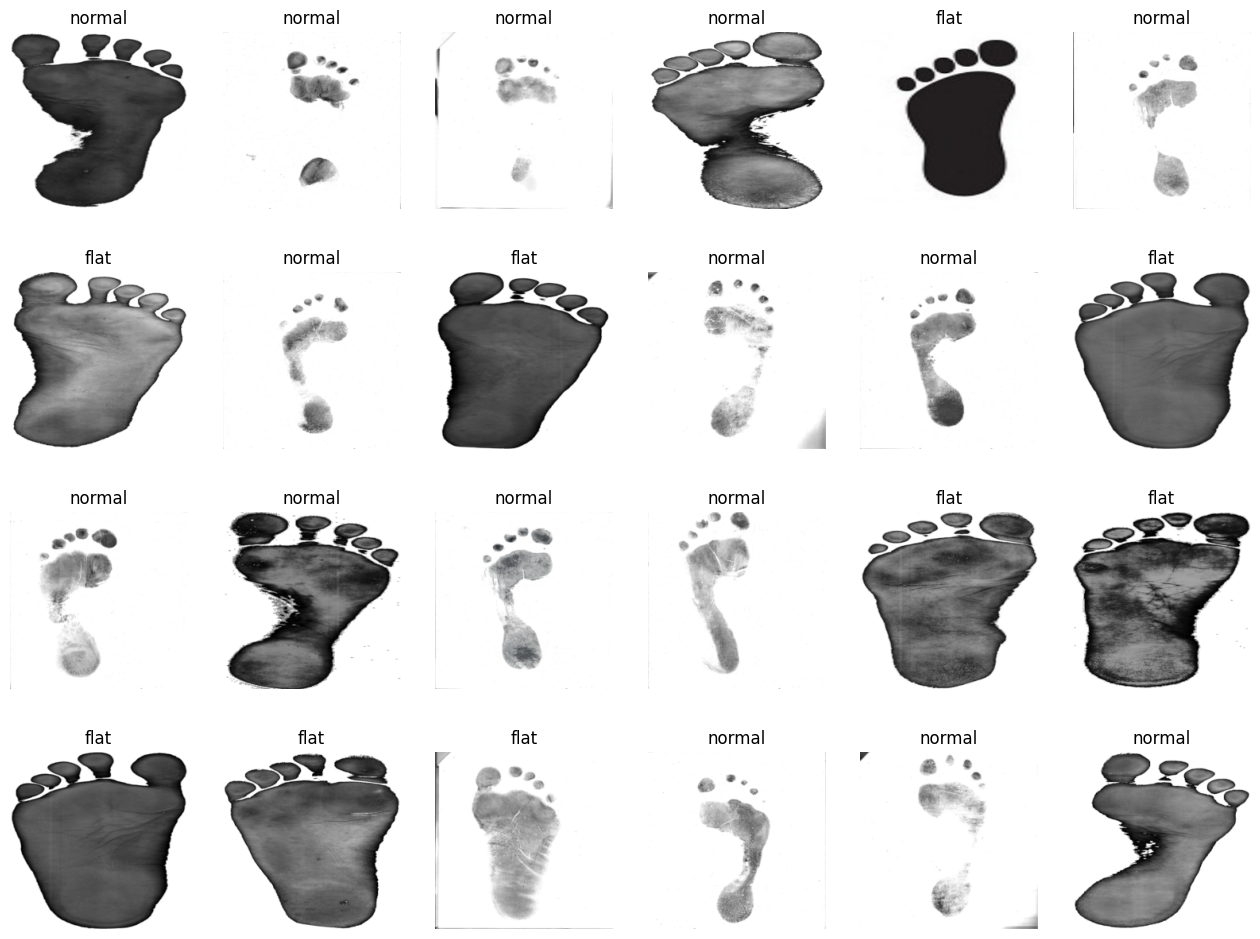

In [7]:
# check dataset
samples, labels = next(iter(train_loader))
classes = {0:'flat',
           1:'normal',
           }
fig = plt.figure(figsize=(16,24))
for i in range(24):
    a = fig.add_subplot(4,6,i+1)
    a.set_title(classes[labels[i].item()])
    a.axis('off')
    a.imshow(np.transpose(samples[i].numpy(), (1,2,0)))
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

## 전이 학습을 위한 코드 추가

In [8]:
# 모델 변경 가능
resnet50 = models.resnet50(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 251MB/s]


In [9]:
def set_parameter_requires_grad(model, feature_extracting=True):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
            
set_parameter_requires_grad(resnet50)

In [10]:
resnet50.fc = nn.Linear(2048, 2)

In [11]:
for name, param in resnet50.named_parameters():
    if param.requires_grad:
        print(name, param.data)

fc.weight tensor([[-0.0100, -0.0100, -0.0091,  ..., -0.0048,  0.0046, -0.0005],
        [-0.0147,  0.0187,  0.0029,  ...,  0.0003,  0.0190,  0.0105]])
fc.bias tensor([0.0126, 0.0188])


In [12]:
model = models.resnet50(pretrained = True)

for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(2048, 2)

for param in model.fc.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(model.fc.parameters())
cost = torch.nn.CrossEntropyLoss()
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [13]:
# TL-update parameter
params_to_update = []
for name,param in resnet50.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)
            
optimizer = optim.Adam(params_to_update)

	 fc.weight
	 fc.bias


# Training and Test

In [14]:
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=10, is_train=True):
    since = time.time()    
    acc_history = []
    loss_history = []
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            model.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloaders.dataset)
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)

        print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        loss_history.append(epoch_loss)        
        torch.save(model.state_dict(), os.path.join('flatfeet/', '{0:0=2d}.pth'.format(epoch)))
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))    
    return acc_history, loss_history

In [15]:
def eval_model(model, dataloaders, device):
    since = time.time()    
    acc_history = []
    best_acc = 0.0

    saved_models = glob.glob('flatfeet/' + '*.pth')
    saved_models.sort()
    print('saved_model', saved_models)

    for model_path in saved_models:
        print('Loading model', model_path)

        model.load_state_dict(torch.load(model_path))
        model.eval()
        model.to(device)
        running_corrects = 0

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                outputs = model(inputs)

            _, preds = torch.max(outputs.data, 1)           
            preds[preds >= 0.5] = 1
            preds[preds < 0.5] = 0
            running_corrects += preds.eq(labels).int().sum()
            
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)
        print('Acc: {:.4f}'.format(epoch_acc))
        
        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        print()

    time_elapsed = time.time() - since
    print('Validation complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))
    
    return acc_history



### Resnet 50


In [16]:
# 전이 학습 training
TL_train_acc_hist, TL_train_loss_hist = train_model(resnet50, train_loader, cost, optimizer, device)

# 전이 학습 test
TL_val_acc_hist = eval_model(resnet50, test_loader, device)

Epoch 0/9
----------
Loss: 0.5803 Acc: 0.7050

Epoch 1/9
----------
Loss: 0.3742 Acc: 0.8400

Epoch 2/9
----------
Loss: 0.3265 Acc: 0.8850

Epoch 3/9
----------
Loss: 0.2531 Acc: 0.9200

Epoch 4/9
----------
Loss: 0.1989 Acc: 0.9400

Epoch 5/9
----------
Loss: 0.1634 Acc: 0.9700

Epoch 6/9
----------
Loss: 0.1548 Acc: 0.9600

Epoch 7/9
----------
Loss: 0.1916 Acc: 0.9400

Epoch 8/9
----------
Loss: 0.2565 Acc: 0.9000

Epoch 9/9
----------
Loss: 0.2121 Acc: 0.9300

Training complete in 1m 55s
Best Acc: 0.970000
saved_model ['flatfeet/00.pth', 'flatfeet/01.pth', 'flatfeet/02.pth', 'flatfeet/03.pth', 'flatfeet/04.pth', 'flatfeet/05.pth', 'flatfeet/06.pth', 'flatfeet/07.pth', 'flatfeet/08.pth', 'flatfeet/09.pth']
Loading model flatfeet/00.pth
Acc: 0.8095

Loading model flatfeet/01.pth
Acc: 0.8452

Loading model flatfeet/02.pth
Acc: 0.8810

Loading model flatfeet/03.pth
Acc: 0.9286

Loading model flatfeet/04.pth
Acc: 0.7857

Loading model flatfeet/05.pth
Acc: 0.8929

Loading model flatfeet

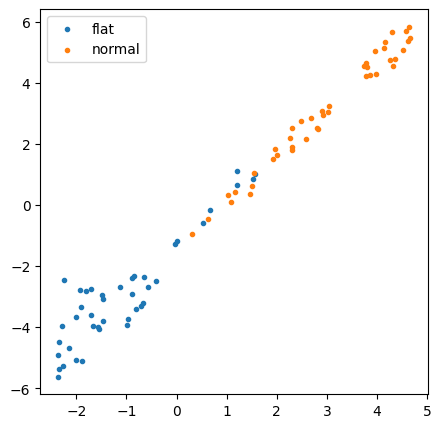

In [17]:
# 전이 학습 TSNE
actual = []
deep_features = []

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        features = resnet50(images)

        deep_features += features.cpu().numpy().tolist()
        actual += labels.cpu().numpy().tolist()

from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
cluster = np.array(tsne.fit_transform(np.array(deep_features)))
actual = np.array(actual)

plt.figure(figsize=(5, 5))
name = ['flat', 'normal']
for i, label in zip(range(2), name):
    idx = np.where(actual == i)
    plt.scatter(cluster[idx, 0], cluster[idx, 1], marker='.', label=label)

plt.legend()
plt.show()